### 데이터 불러오기

In [1]:
from collections import Counter, defaultdict
from konlpy.tag import Mecab, Komoran
from utils import *
mecab = Mecab()
komoran = Komoran()
file_path = './data/train_jsonl_ma_komoran.txt'

In [2]:
app_id_list, ratings_lists, ma_lists = read_jsonl(file_path)

Reading documents: 100%|██████████| 2984/2984 [00:13<00:00, 227.80it/s]


사전 만들기

In [3]:
major_pos = ["NNG", "NNP", "NP", "XR", "VV", "VA", "MAG", "MAJ"]

In [4]:
full_morph = ['NNG','NNP','NNB','NR','NP','VV','VA','VX','VCP','VCN','MM','MAG','MAJ','IC']
empty_morph = ['JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JX','JC','EP'
               'EF','EC','ETN','ETM','XPN','XSN','XSV','XSA']
egun = ['XR']
signs = ['SF','SE','SS','SP','SO','SW']
not_koreans = ['SL','SH','SN']

In [4]:
make_dict = Make_dictionay()

주요 품사별로 뽑으면 이렇게 된다

In [5]:
make_dict.fit(ma_lists, choose_pos=major_pos, normal_dict_option=1)

Processing: 100%|██████████| 2984/2984 [00:12<00:00, 244.13it/s]


In [6]:
make_dict.word_count.most_common(10)

[('좋다/VA', 122849),
 ('하다/VV', 116730),
 ('있다/VV', 78138),
 ('삭제/NNG', 67567),
 ('쓰다/VV', 64838),
 ('되다/VV', 62343),
 ('구매/NNG', 57831),
 ('안/NNG', 56520),
 ('어플/NNP', 56208),
 ('앱/NNP', 55219)]

## 어휘 Searching

In [42]:
from operator import itemgetter
# sort 방법
def sord_dict(query, reverse, word_count):
    """
    query:
     - 0: 숫자, 영어, 가나다 순
     - 1: count 순
    """
    morph_counts = [(w, c) for w, c in word_count.items()]
    if isinstance(query, list):
        for q, r in zip(query, reverse):
            morph_counts = sorted(morph_counts, key=itemgetter(q), reverse=r)
    else:
        morph_counts = sorted(morph_counts, key=itemgetter(query), reverse=reverse)
    return morph_counts

In [48]:
sord_dict([1, 0], [True, True], make_dict.word_count)[:10]

[('힝/MAG', 65),
 ('힙합/NNG', 8),
 ('힙합 음악/NNP', 1),
 ('힙스터/NNP', 2),
 ('힙/NNP', 29),
 ('힘찬/NNP', 1),
 ('힘차다/VA', 7),
 ('힘줄/NNG', 1),
 ('힘주다/VV', 2),
 ('힘입다/VV', 3)]

## 어휘 시각화

In [10]:
def draw_zipian(word_count):
    counts = sorted(word_count.values(), reverse=True)
    plt.figure(figsize=(8, 8), dpi=80)
    plt.plot(counts, color='blue', marker='o')
    plt.title("Zip's Curve", fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('log(Rank)')
    plt.ylabel('log(Frequency)')
    plt.show()

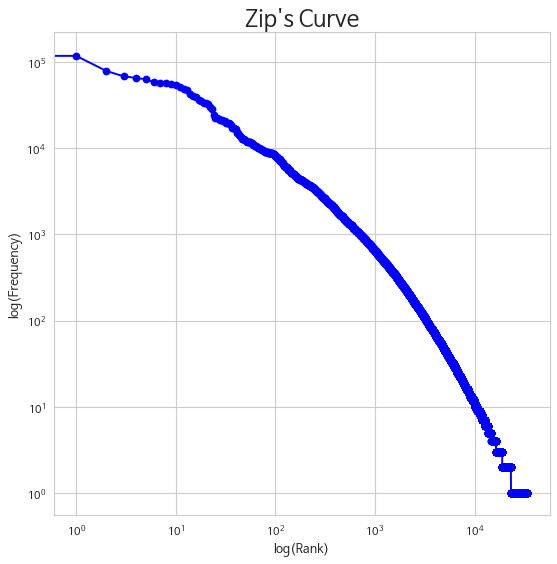

In [11]:
draw_zipian(make_dict.word_count)

## Word Cloud

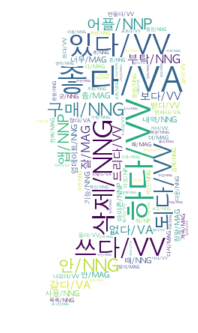

In [7]:
import sys
import wordcloud
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def read_mask(mask_file_name):
    """주어진 이름의 파일에서 마스킹 이미지 데이터를 읽어서 돌려준다."""
    mask = np.array(Image.open(mask_file_name))
    
    return mask

def draw_word_clouds(word_count, mask):    
    font_path = get_font_path()
    cloud = build_cloud(word_count, font_path, mask)
    show_cloud(cloud, mask)
    
def get_font_path():
    """플랫폼에 따라 글꼴 경로를 설정한다."""

    if sys.platform == "win32" or sys.platform == "win64":
        font_path = "C:/Windows/Fonts/malgun.ttf"
    elif sys.platform == "darwin":
        font_path = "/Library/Fonts/AppleGothic.ttf"
        
    return font_path

def build_cloud(word_count, font_path, mask):
    """주어진 어휘 계수 결과와 글꼴 경로를 이용하여 워드 클라우드를 생성하여 돌려준다."""
    NUM_WORDS = 200
    cloud_gen = wordcloud.WordCloud(background_color="white",
                                    font_path=font_path, max_words=NUM_WORDS,
                                    mask=mask, collocations=False)
    cloud = cloud_gen.generate_from_frequencies(word_count)

    return cloud

def show_cloud(cloud, mask):
    """워드 클라우드를 화면에 표시한다."""
    
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
def main(word_counts):
    
    mask_file_name = "./figs/bust.png"
    mask = read_mask(mask_file_name)
    word_count = Counter({l: c for l, c in word_counts.items()})
    draw_word_clouds(word_count, mask)

main(make_dict.word_count)

## 키워드 추출

### TD-IDF

In [6]:
filtered_docs = make_dict.document_transform(ma_lists)

Processing: 100%|██████████| 2984/2984 [00:08<00:00, 346.37it/s]


In [7]:
flat_docs = make_dict.flatten_all_docs(filtered_docs)

Processing: 100%|██████████| 2984/2984 [00:00<00:00, 55761.11it/s]


In [8]:
make_dict.save_as_file('flat_docs', flat_docs)

saving: 100%|██████████| 429343/429343 [00:01<00:00, 389498.79it/s]


tf-idf는 왜 해야하나?

* 문서에서 단어가 여러군데에서 빈출하면 문서의 특징을 나타내지 못함

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer를 쓰려면 약간의 변형이 필요하다.

In [50]:
flat_docs = make_dict.load_file('./data/flat_docs.txt', option_split=False)

In [51]:
tfidf_vec = TfidfVectorizer(vocabulary=make_dict.word_idx)
tfidf_vec.fit(flat_docs)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary={'맨날/MAG': 0, '보이다/VV': 1, '계속/MAG': 2, '돌아가다/VV': 3, '징그럽다/VA': 4, '진짜/MAG': 5, '잘/MAG': 6, '보다/VV': 7, '갑자기/MAG': 8, '없다/VA': 9, '이유/NNG': 10, '뭐/NP': 11, '해외/NNG': 12, '쓰다/VV': 13, '세기/NNG': 14, '경기/NNG': 15, '나오다/VV': 16, '물론/MAG': 17, '특별/XR': 18, '이벤트/NNG': 19, '있다/VV': 20, '이용자/NNG...': 33642, '전자우편/NNP': 33643, '타성/NNG': 33644, '구송/NNG': 33645, '런던/NNG': 33646, '5월 11일/NNP': 33647})

In [52]:
tf_idf_matrix = tfidf_vec.transform(flat_docs).toarray()
tf_idf_matrix.shape

(429343, 33648)

제대로 계산 됐는지 확인해보자 ;;

In [54]:
d1 = tf_idf_matrix[10, :]
d2 = tf_idf_matrix[69, :]
np.dot(d1, d2) / np.linalg.norm(d1)*np.linalg.norm(d2)

/Users/Soo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


nan

In [55]:
np.linalg.norm(d1)

0.0

In [23]:
def get_key_word(tfidf_vec):
    

matrix([[ 0.73833501,  0.47298569,  0.4807764 ]])

## Navie Bayesian Classifier

한 documentation으로 보면, Input A은 문장내에 단어들의 조합이다 $[a_1, a_2 ,\cdots, a_n]$. B는 rating점수다. 각 rating점수에 대해서, 

$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$가 성립하는데, $P(B)$는 사전 확률로 문서내에 각 rating이 나온 횟수로 측정 , $P(A|B)$는 Likelihood다.

Chain rule를 활용하면 Likelihood $\times$ prior 은 아래와 같이 된다.

$P(a_1, a_2 ,\cdots, a_n, B) \\ 
= P(a_1, a_2 ,\cdots, a_n|B)P(B) \\
= P(a_2, \cdots, a_n|B, a_1)P(a_1|B)P(B) \\
= \cdots = P(a_n|B, a_1, \cdots, a_{n-1}) \cdots P(a_1|B)P(B)$

여기서 $P(B)$를 제외한 부분은 구하기 어렵기 때문에 Navie가정을 하여($a_i$는 각기 다른 $a_i$과 독립이며, B에 대하여 조건부 독립이다) 계산. 즉,

$P(a_1|B) = P(a_1|B)\\
P(a_2|B, a_1) = P(a_2|B)\\
\quad \vdots \\
P(a_n|B, a_1, \cdots, a_{n-1}) = P(a_n|B)$

가 되는 것이고 종합하게 되면 $ P(a_1, a_2 ,\cdots, a_n, B) = \prod_{i=1}^{n}{P(a_i|B)}P(B)$ 가 된다.

In [ ]:
class NavieBayesian(object):
    def __init__(self)

## Doc2vec

In [20]:
from gensim.models import Doc2Vec, Word2Vec

---

Compressed Sparse Row matrix

데이터가 sparse 할 때 쓰면 좋은 것 (0이 많고 값이 중간에 듬성듬성있는것들)

In [11]:
from scipy.sparse import csr_matrix

In [12]:
docs = [["hello", "world", "hello"], ["goodbye", "cruel", "world"]]
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in docs:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary)) 
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

In [106]:
csr_matrix((data, indices, indptr), dtype=int).toarray()

array([[2, 1, 0, 0],
       [0, 1, 1, 1]])